In [1]:

#%pip install tensorflow[and-cuda]
#%pip install matplotlib
#%pip install -q kaggle
#%pip install python-dotenv
#%pip install opencv-python
#%pip install pydot
#%pip install pyyaml h5py

In [2]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from dotenv import load_dotenv
from zipfile import ZipFile
import cv2

load_dotenv()

2024-01-20 19:25:27.447983: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-20 19:25:27.448026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-20 19:25:27.448730: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-20 19:25:27.454163: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-20 19:25:28.124720: W tensorflow/compiler/tf2

True

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


2024-01-20 19:25:29.202948: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-20 19:25:29.222312: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-20 19:25:29.222519: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


The following step loads the images from the dataset.

It also deletes the images that are corrupted or that don't actually exist. 

Problem: This results in an imbalanced dataset since there could be more corrupted images that correspond to a class or to another.

Solution: Leave it be or remove the corresponding ID in the other class (e.g. if the image from class Fire with id 100 is removed, the image id 100 Non Fire will be also removed)

It is also important to verify if there are corrupt images in the testing dataset. If there are any, they also need to be removed.

In [4]:
from dataset import download_dataset
from dataset import display_dataset_images


download_bool = False
display_bool = False
if download_bool:
    download_dataset()

if display_bool:
    display_dataset_images()

In [5]:
TRAIN_DATA_DIR = '../datasets/Data/Train_Data/'
TEST_DATA_DIR = '../datasets/Data/Test_Data/'
IMG_HEIGHT = 224 # Max size allowed for MobileNetV2
IMG_WIDTH = 224 # Max size allowed for MobileNetV2
SEED = 123
BATCH_SIZE = 8
CHANNELS = 3

from dataset import prepare_datasets
train_ds, val_ds, test_ds = prepare_datasets(TRAIN_DATA_DIR, TEST_DATA_DIR, IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, SEED)

Found 4609 files belonging to 2 classes.
Using 3688 files for training.


2024-01-20 19:25:37.007369: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-20 19:25:37.007663: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-20 19:25:37.007882: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-20 19:25:37.234719: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-20 19:25:37.235041: I external/local_xla/xla/stream_executor

Found 4609 files belonging to 2 classes.
Using 921 files for validation.
Found 50 files belonging to 2 classes.


In [6]:
from forest_fire_model import mobile_net_transfer_learning, mobile_net_transfer_learning, forest_fire_model


base_model, preprocess_input = mobile_net_transfer_learning(IMG_HEIGHT, IMG_WIDTH, CHANNELS, train_ds)
model = forest_fire_model(preprocess_input, base_model, train_ds, val_ds, test_ds, load=True, path='feature_extraction_model.h5')


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

2024-01-20 19:25:47.988485: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


(8, 7, 7, 1280)


In [14]:
# Positive values predict class 1 -> Non Fire
# Negative values predict class 0 -> Fire
y_hat = model.predict(test_ds)
y_hat[y_hat > 0] = 1
y_hat[y_hat < 0] = 0
print(y_hat)

7/7 [==============================] - 0s 18ms/step
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [15]:
def predict_fire(model, batch):
    y_hat = model.predict(batch)
    # y_hat[y_hat > 0] = 1
    # y_hat[y_hat < 0] = 0
    
    # if y_hat > 1:
    #     return 'Non Fire'
    # else:
    #     return 'Fire'

    return np.where(y_hat > 0, 'Non Fire', 'Fire')

[0 0 0 0 0 0 0 0]
1/1 [==============================] - 0s 20ms/step
[['Fire']
 ['Fire']
 ['Fire']
 ['Fire']
 ['Fire']
 ['Fire']
 ['Fire']
 ['Fire']]
[0 0 0 0 0 0 0 0]
1/1 [==============================] - 0s 22ms/step
[['Fire']
 ['Fire']
 ['Fire']
 ['Fire']
 ['Fire']
 ['Fire']
 ['Fire']
 ['Fire']]
[0 0 0 0 0 0 0 0]
1/1 [==============================] - 0s 22ms/step
[['Fire']
 ['Fire']
 ['Fire']
 ['Fire']
 ['Fire']
 ['Fire']
 ['Fire']
 ['Fire']]
[0 1 1 1 1 1 1 1]
1/1 [==============================] - 0s 22ms/step
[['Fire']
 ['Fire']
 ['Fire']
 ['Non Fire']
 ['Non Fire']
 ['Non Fire']
 ['Non Fire']
 ['Non Fire']]
[1 1 1 1 1 1 1 1]
1/1 [==============================] - 0s 20ms/step
[['Non Fire']
 ['Non Fire']
 ['Non Fire']
 ['Non Fire']
 ['Fire']
 ['Non Fire']
 ['Non Fire']
 ['Non Fire']]


IndexError: index 4 is out of bounds for axis 1 with size 4

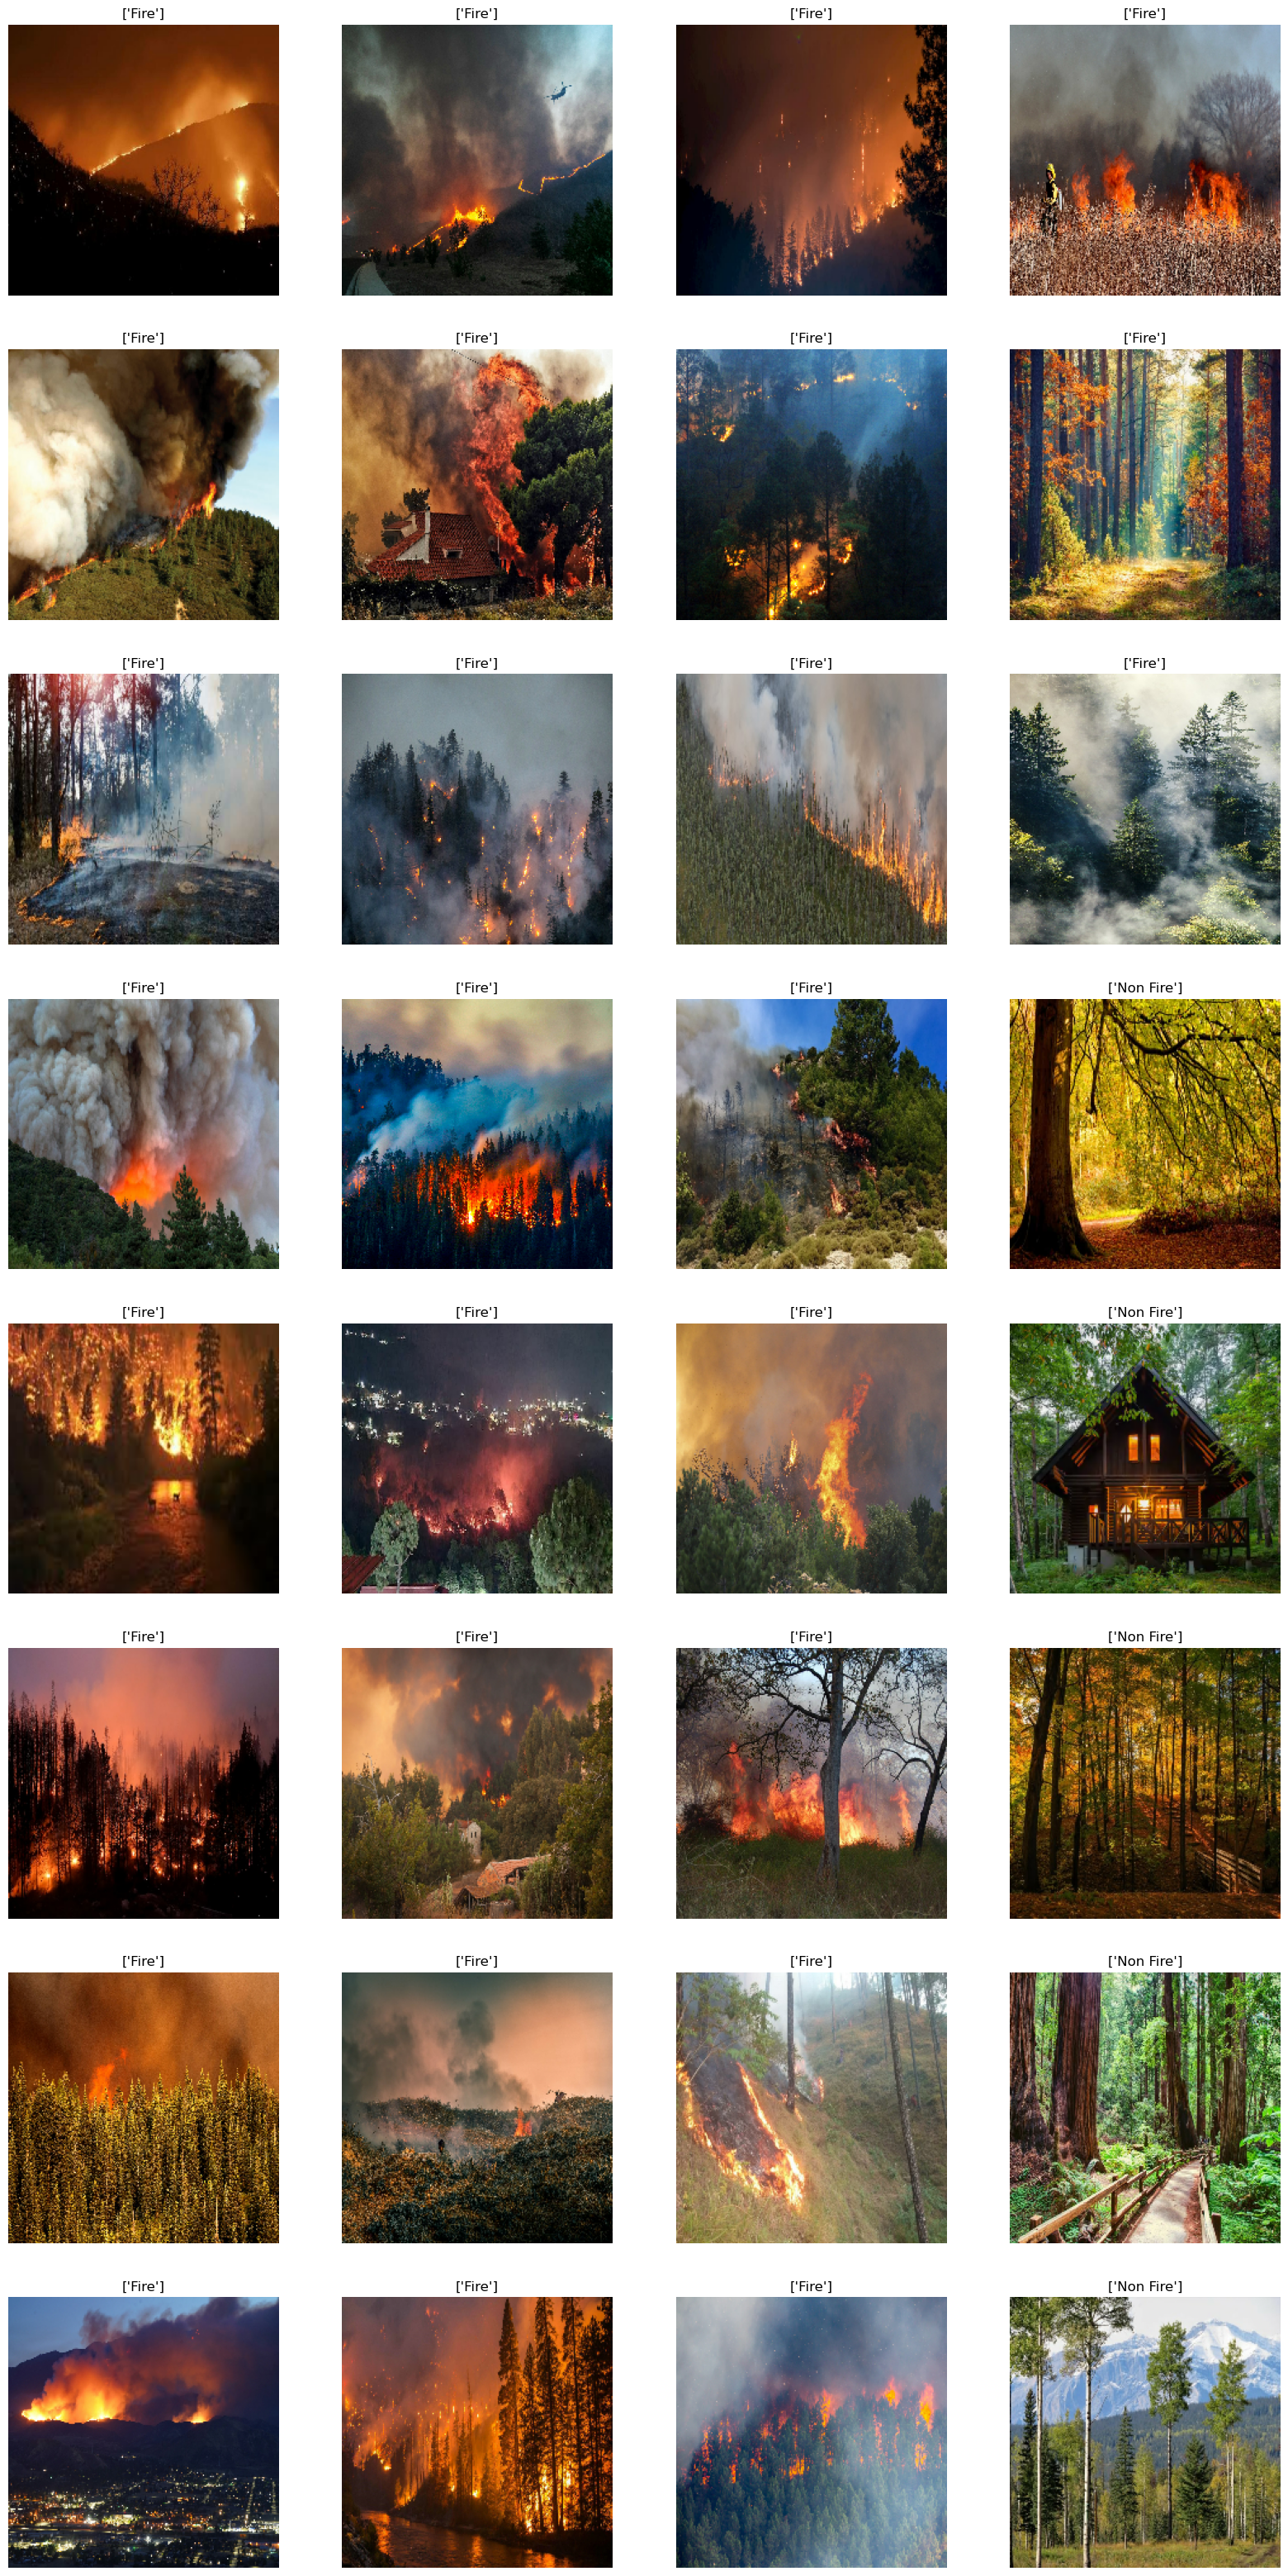

In [19]:
fig, ax = plt.subplots(nrows=8, ncols=4, figsize=(20, 40))
j = 0
for batch_x, batch_y in test_ds:
    print(batch_y.numpy())
    predicted_batch = predict_fire(model, batch_x)
    print(predicted_batch)
    for i, x in enumerate(batch_x):
        #cv2.imshow('image', x)
        ax[i, j].imshow(x.numpy().astype("uint8"))
        ax[i, j].axis("off")
        predicted_label = predicted_batch[i]
        ax[i, j].set_title(f'{predicted_label}')
    j+=1
plt.show()

In [ ]:
def video_to_frames(input_loc, output_loc):
    """Function to extract frames from input video file
    and save them as separate frames in an output directory.
    Args:
        input_loc: Input video file.
        output_loc: Output directory to save the frames.
    Returns:
        None
    """
    try:
        os.mkdir(output_loc)
    except OSError:
        pass
    # Log the time
    time_start = time.time()
    # Start capturing the feed
    cap = cv2.VideoCapture(input_loc)
    # Find the number of frames
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    print ("Number of frames: ", video_length)
    count = 0
    print ("Converting video..\n")
    # Start converting the video
    while cap.isOpened():
        # Extract the frame
        ret, frame = cap.read()
        if not ret:
            continue
        # Write the results back to output location.
        cv2.imwrite(output_loc + "/%#05d.jpg" % (count+1), frame)
        count = count + 1
        # If there are no more frames left
        if (count > (video_length-1)):
            # Log the time again
            time_end = time.time()
            # Release the feed
            cap.release()
            # Print stats
            print ("Done extracting frames.\n%d frames extracted" % count)
            print ("It took %d seconds forconversion." % (time_end-time_start))
            break


input_loc = 'Wildfires_101_National_Geographic.mp4'
output_loc = '/path/to/output/frames/'
video_to_frames(input_loc, output_loc)
